In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
input_img = Input(shape=(18, 12, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (2, 2), activation='relu', padding='same')(input_img)
print x.shape
x = MaxPooling2D((2, 2), padding='same')(x)
print x.shape
x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
print x.shape
#x = MaxPooling2D((3, 2), padding='same')(x)
#print x.shape
#x = Conv2D(8, (3, 2), activation='relu', padding='same')(x)
#print x.shape
encoded = MaxPooling2D((3, 2), padding='same')(x)
print encoded.shape

# at this point the representation is ### altered(3, 3, 8) i.e. 128-dimensional
print 'This is the bottleneck'

x = Conv2D(8, (2, 2), activation='relu', padding='same')(encoded)
print x.shape
x = UpSampling2D((3, 2))(x)
print x.shape
#x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
print x.shape
x = UpSampling2D((2, 2))(x)
print x.shape
decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)
print decoded.shape

autoencoder = Model(input_img, decoded)

(?, 18, 12, 16)
(?, 9, 6, 16)
(?, 9, 6, 8)
(?, 3, 3, 8)
This is the bottleneck
(?, 3, 3, 8)
(?, 9, 6, 8)
(?, 9, 6, 16)
(?, 18, 12, 16)
(?, 18, 12, 1)


In [139]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(3, 3, 8))
# retrieve the last layer of the autoencoder model
decoder_layers = autoencoder.layers[-5:]

In [141]:
composed_model = decoder_layers[0](encoded_input)
composed_model = decoder_layers[1](composed_model)
composed_model = decoder_layers[2](composed_model)
composed_model = decoder_layers[3](composed_model)
composed_model = decoder_layers[4](composed_model)

In [142]:
# create the decoder model
decoder = Model(encoded_input, composed_model)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
df_mira = pd.read_csv('ATLAS_LC/MIRA_features_table.csv')
signature_cols = [col for col in df_mira.columns if 'Signature' in col]
signature_cols += ['OBJID', 'filter', 'CLASS']
df_mira = df_mira[signature_cols]

In [23]:
df_mpulse = pd.read_csv('ATLAS_LC/MPULSE_features_table.csv')[signature_cols]
df_dbf = pd.read_csv('ATLAS_LC/DBF_features_table.csv')[signature_cols]
df_lpv = pd.read_csv('ATLAS_LC/LPV_features_table.csv')[signature_cols]
df_dbh = pd.read_csv('ATLAS_LC/DBH_features_table.csv')[signature_cols]
df_pulse = pd.read_csv('ATLAS_LC/PULSE_features_table.csv')[signature_cols]
df_nsine = pd.read_csv('ATLAS_LC/NSINE_features_table.csv')[signature_cols]
df_sine = pd.read_csv('ATLAS_LC/SINE_features_table.csv')[signature_cols]
df_msine = pd.read_csv('ATLAS_LC/MSINE_features_table.csv')[signature_cols]
df_cbh = pd.read_csv('ATLAS_LC/CBH_features_table.csv')[signature_cols]
df_cbf = pd.read_csv('ATLAS_LC/CBF_features_table.csv')[signature_cols]
df_irr = pd.read_csv('ATLAS_LC/IRR_features_table.csv')[signature_cols]

In [27]:
full_data = pd.concat([df_mira, df_mpulse, df_dbf, df_lpv, df_dbh, df_pulse, 
                       df_nsine, df_sine, df_msine, df_cbf, df_cbh], sort=False)

X = full_data[signature_cols].values

In [28]:
del(df_mira)
del(df_dbf)
del(df_lpv)
del(df_dbh)
del(df_pulse)
del(df_nsine)
del(df_sine)
del(df_msine)
del(df_cbh)
del(df_cbf)
del(df_irr)

In [56]:
data = X.reshape(X.shape[0], 18, 12, 1)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test = train_test_split(data, test_size=0.10, random_state=17)

In [47]:
print(X_train[0].shape)
print(X_test.shape)

(18, 12, 1)
(36254, 18, 12, 1)


In [143]:
from keras.callbacks import TensorBoard

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=6000,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 326278 samples, validate on 36254 samples
Epoch 1/50
326278/326278 [==============================] - 48s 146us/step - loss: 0.4767 - val_loss: 0.1628
Epoch 2/50
326278/326278 [==============================] - 50s 153us/step - loss: 0.0869 - val_loss: -0.1390
Epoch 3/50
326278/326278 [==============================] - 51s 155us/step - loss: -0.1616 - val_loss: -0.2972
Epoch 4/50
326278/326278 [==============================] - 49s 149us/step - loss: -0.3417 - val_loss: -0.4117
Epoch 5/50
326278/326278 [==============================] - 48s 147us/step - loss: -0.4842 - val_loss: -0.5430
Epoch 6/50
326278/326278 [==============================] - 52s 160us/step - loss: -0.5734 - val_loss: -0.6359
Epoch 7/50
326278/326278 [==============================] - 56s 172us/step - loss: -0.6323 - val_loss: -0.6740
Epoch 8/50
326278/326278 [==============================] - 57s 175us/step - loss: -0.6830 - val_loss: -0.7151
Epoch 9/50
326278/326278 [==============================] - 56s 

In [144]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
# encode and decode some lightcurves
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [145]:
decoded_imgs_full = autoencoder.predict(X_test)

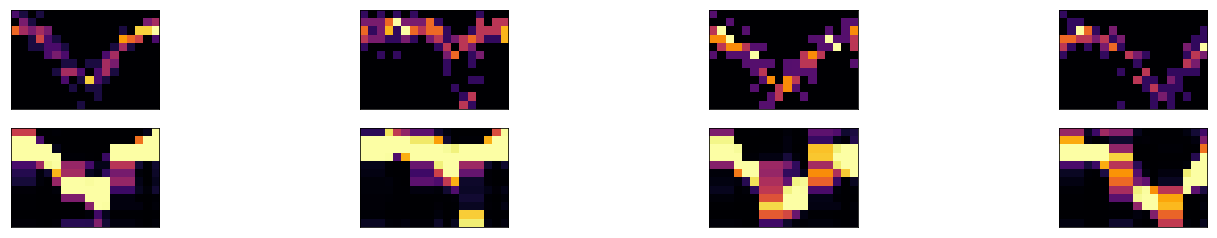

In [146]:
n = 4  # how many digits we will display
plt.figure(figsize=(24, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    j = np.random.randint(0, high=len(X_test))
    plt.imshow(X_test[j, :, :, 0].T, cmap='inferno')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_full[j, :, :, 0].T, cmap='inferno')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()